In [1]:
%load_ext autoreload
%autoreload 2

10:19:07 - INFO: Sampling 4 new images....
699it [01:04, 10.82it/s]


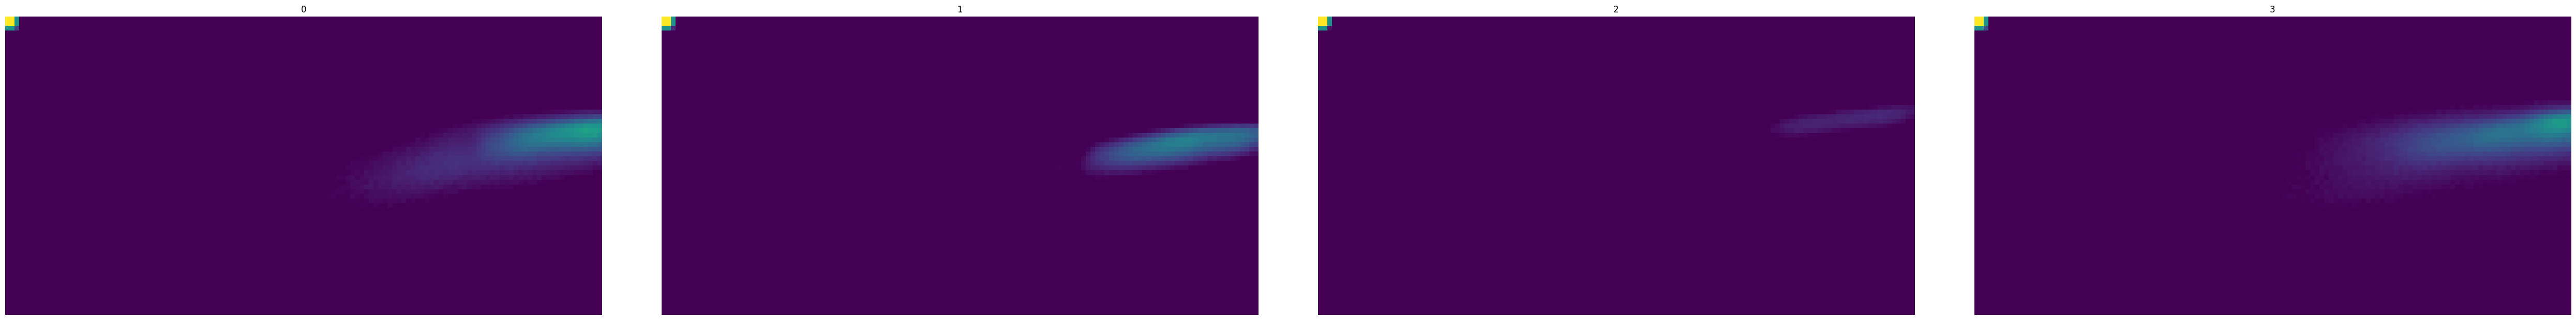

In [3]:
from ddpm_conditional import *
from utils import plot_images, plot_images_from_dir

n = 4
device = "cuda:2"
model = UNet_conditional(img_width=128, img_height=64, feat_num=3, device=device).to(device)
ckpt = torch.load("models/CFG_700_norm_fing/ema_ckpt.pt")
model.load_state_dict(ckpt)
diffusion = Diffusion(img_width=128, img_height=64, device=device, noise_steps=700)
y = torch.Tensor([13,15,20]).to(device).float().unsqueeze(0) # parameter vector
x = diffusion.sample(model, n, y, cfg_scale=10)
plot_images(x)
save_samples(x)

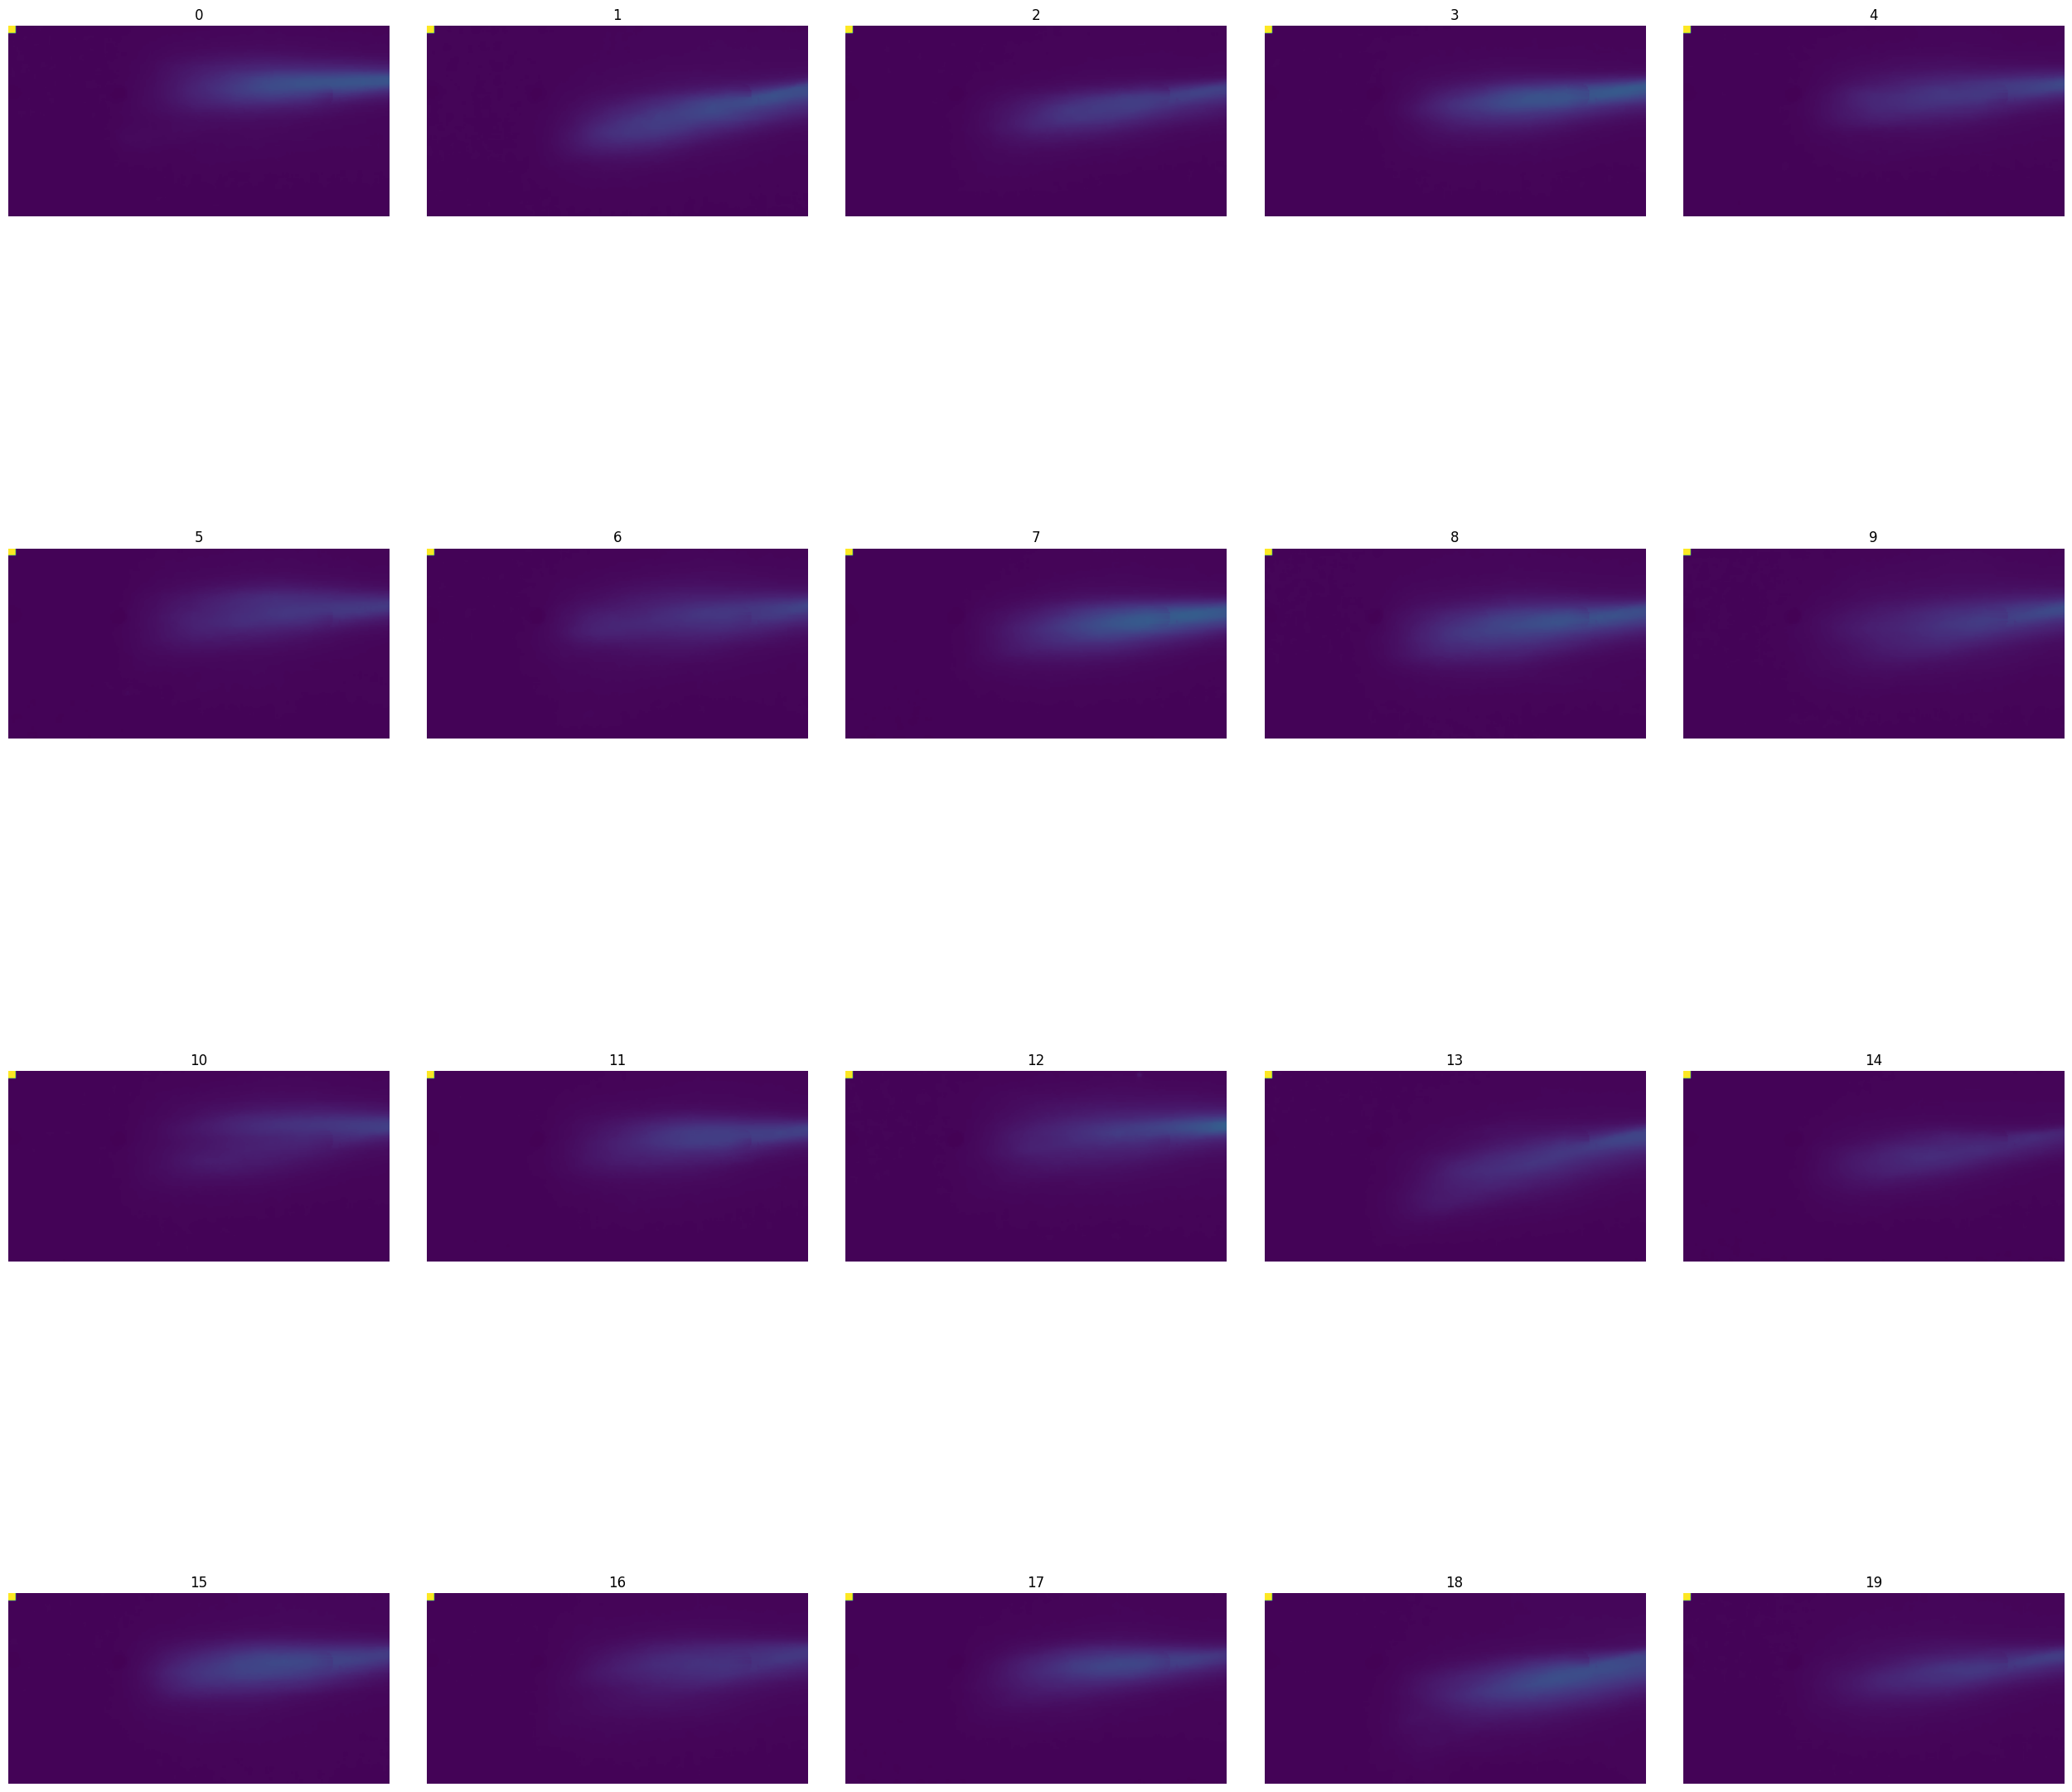

In [6]:
plot_images_from_dir("train/4", 20)